# Assignment n°2

In [16]:
import numpy as np 
import pandas as pd 

from matplotlib.pyplot import subplots 
from plotnine import *

import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

from sklearn.model_selection import train_test_split

from functools import partial
from sklearn.model_selection import ( \
    cross_validate,
    KFold,
    ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

from sklearn.utils import shuffle

from tqdm import tqdm

import warnings

import json

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
  
# metadata 
print(communities_and_crime.metadata) 
  
# variable information 
print(communities_and_crime.variables) 


{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'ID': 405, 'type': 'NATIVE', 'title': 'A data-driven software tool for enabling cooperative information s

In [18]:
X.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,?,0.02,0.12,0.45,?,?,?,?,0.00,?
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,?,0.01,0.21,0.02,?,?,?,?,0.00,?
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,?,0.02,0.39,0.28,?,?,?,?,0.00,?
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,?,0.04,0.09,0.02,?,?,?,?,0.00,?


In [19]:
X = X.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1)
X.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,?,0.02,0.12,0.45,?,?,?,?,0.00,?
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,?,0.01,0.21,0.02,?,?,?,?,0.00,?
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,?,0.02,0.39,0.28,?,?,?,?,0.00,?
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,?,0.04,0.09,0.02,?,?,?,?,0.00,?


In [20]:
y.head()

,ViolentCrimesPerPop
0,0.20
1,0.67
2,0.43
3,0.12
4,0.03


In [21]:
X.replace('?', np.nan, inplace=True)

null_counts = X.isnull().sum()

# Filter columns with more than 0 nulls
null_counts = null_counts[null_counts > 0]

# Print the result
print(null_counts)

OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64


In [22]:
# Identify columns where conversion to numeric fails
for col in X.columns:
    try:
        X[col] = pd.to_numeric(X[col], errors='raise')
    except ValueError:
        print(f"Column '{col}' contains non-numeric values")


In [23]:
X.dtypes[X.dtypes != np.float64]
# Good, everything has been converted to numerical !
# Now we can deal with Null values

Series([], dtype: object)

In [24]:
X['OtherPerCap'] = X['OtherPerCap'].fillna(X['OtherPerCap'].mean()) # Since there is 1 value missing, we replace with the mean

null_counts.drop('OtherPerCap', inplace=True) # We drop the 'OtherPerCap' from null_count table since this column has no missing values anymore
X.drop(null_counts.index.to_list(), axis=1, inplace=True) # For other, since there is too many missing, values, we drop this features from X
X.info

<bound method DataFrame.info of       population  householdsize  racepctblack  racePctWhite  racePctAsian  \
0           0.19           0.33          0.02          0.90          0.12   
1           0.00           0.16          0.12          0.74          0.45   
2           0.00           0.42          0.49          0.56          0.17   
3           0.04           0.77          1.00          0.08          0.12   
4           0.01           0.55          0.02          0.95          0.09   
...          ...            ...           ...           ...           ...   
1989        0.01           0.40          0.10          0.87          0.12   
1990        0.05           0.96          0.46          0.28          0.83   
1991        0.16           0.37          0.25          0.69          0.04   
1992        0.08           0.51          0.06          0.87          0.22   
1993        0.20           0.78          0.14          0.46          0.24   

      racePctHisp  agePct12t21  agePct12t29

In [25]:
X.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.100400,0.231134,0.204329,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.000000,0.060000,0.470000,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000,0.000000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.000000,0.130000,0.630000,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000,0.000000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.000000,0.280000,0.777500,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
def outlier_summary(df):
    outlier_info = {}

    for column in df.select_dtypes(include=['float', 'int']):  # Only numerical columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_proportion = outlier_count / df.shape[0]

        outlier_info[column] = {
            'Outlier Count': outlier_count,
            'Outlier Proportion': outlier_proportion
        }
    
    return pd.DataFrame(outlier_info).T  # Transpose for better readability

outlier_summary_df = outlier_summary(X)
print(outlier_summary_df) # I use the 'Data Wrangler' extension of VSCode to better see the results.

                     Outlier Count  Outlier Proportion
population                   218.0            0.109328
householdsize                 84.0            0.042126
racepctblack                 217.0            0.108826
racePctWhite                  77.0            0.038616
racePctAsian                 216.0            0.108325
...                            ...                 ...
PctSameState85                90.0            0.045135
LandArea                     159.0            0.079739
PopDens                      158.0            0.079238
PctUsePubTrans               207.0            0.103811
LemasPctOfficDrugUn          309.0            0.154965

[100 rows x 2 columns]


We can see that our dataset contains many outliers. Using RMSE or R2 is maybe not the best metric top compute the score.

# Implementation
Now that the preprocessing is done, having a X and y clean, let's implements the assigmenet methods.

In [27]:
# Function to check if the method given to compute the score  exists: 
score_methods_array = ['RMSE', 'R2', 'MAE', 'MAPE', 'MSLE']

def method_score_raise_error(score_method_used):
    raise ValueError(f"Score {score_method_used} is not supported or does not exist. Choose your scores between {', '.join(score_methods_array)}.")

## Cross Validation and leave-one-out method
### Cross Validation

In [28]:
# First let's code the function eval_MSE used in ISLP to evalutate the MSE given the features we want to include in the model
def evalscore_for_linear_regression(terms, X_train, y_train, X_test, y_test, score_method_used='RMSE'):
    '''
    Calculate the Mean Squared Error (MSE) between predicted and actual values.

    Parameters:
    ----------
    terms : array-like, shape (n_selected_features,)
        The predictor variables (or features) used in the model.
        
    X_train : array-like, shape (n_samples_train, n_features)
        Training data from the original preprocessed dataFrame (without the target column)
        
    y_test : array-like, shape (n_samples_train,)
        The target value column of the original preprocessed dataFrame used for training.

    X_test : array-like, shape (n_samples_test, n_features)
        Testing data from the original preprocessed dataFrame (without the target column)
        
    y_test : array-like, shape (n_samples_test,)
        The target value column of the original preprocessed dataFrame used for testing.

    score_method_used : string
        The used method to compute the score of our model.

    Returns:
    --------
    mse : float
        The calculated mean squared error on the test data.
    '''

    #intercept_train = pd.DataFrame({'intercept' : np.ones(X_train.shape[0])}, index=X_train.index)
    #X_train = pd.concat([intercept_train, X_train[terms]], axis=1) # Construction of the X_train transform to use the linear regression of sklearn or statsmodels

    #intercept_test = pd.DataFrame({'intercept' : np.ones(X_train.shape[0])}, index=X_train.index)
    # X_test = pd.concat([intercept_test, X_test[terms]], axis=1)

    # I wanted to do it by hand but the .predict function needs .fit_transform and .transform specifically.

    mm = MS(terms)

    X_train = mm.fit_transform(X_train)
    X_test = mm.transform(X_test)

    y_train = y_train['ViolentCrimesPerPop']
    y_test = y_test['ViolentCrimesPerPop']

    results = sm.OLS(y_train, X_train).fit()
    test_pred = results.predict(X_test)

    match score_method_used:
        case 'RMSE':
            # Root Mean Squared Error
            return np.sqrt(np.mean((y_test - test_pred)**2))
        case 'R2':
            # Coefficient of determination R^2
            ss_res = np.sum((y_test - test_pred) ** 2)
            ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
            return 1 - (ss_res / ss_tot)
        case 'MAE':
            # Mean Absolute Error
            return np.mean(np.abs(y_test - test_pred))
        case 'MAPE':
            # Mean Absolute Percentage Error
            return np.mean(np.abs((y_test - test_pred) / y_test)) * 100
        case 'MSLE':
            # Mean Squared Logarithmic Error
            return np.mean((np.log1p(y_test) - np.log1p(test_pred)) ** 2)
        case _:
            # Default case: raise an error if score method is not recognized
            method_score_raise_error(score_method_used)

    

In [29]:
def k_fold_CV(X, y, terms, k=5, score_method_used='RMSE', tqdm_disable=''):
    '''
    Calculate the MSE using k-fold Cross Validation method.

    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        Data from the original preprocessed dataFrame (without the target column)
        
    y : array-like, shape (n_samples,)
        The target value column of the original preprocessed dataFrame.

    terms : array-like, shape (n_selected_features,)
        The predictor variables (or features) used in the model.
        
    k : integer
        number of cross validation

    score_method_used : string
        The used method to compute the score of our model.

    tqdm_disable : char
        If it is empty, it enables tqdm progression, but if there is a charcter or a string, disable tqdm progression.
        Disable progresson it when it is too heavy to watch the process of the loops, especially when this function is 
        called numerous times.

    Returns:
    --------
    mse : float
        The mean of different calculated mean squared error on the test data for different folds.
    '''

    # check if k is valid
    if k > X.shape[0]:
        raise ValueError(f"k cannot be greater than the number of samples. k={k}, but X contains only {X.shape[0]} samples.")

    k_score = np.zeros(k)

    # shuffle the data
    X_shuffled, y_shuffled = shuffle(X, y, random_state=1)

    # Split the data
    X_parts = np.array_split(X_shuffled, k)
    y_parts = np.array_split(y_shuffled, k)

    for i in tqdm(range(k), disable=tqdm_disable):
        # Define test and train sets
        X_test = X_parts[i]
        y_test = y_parts[i]

        # X_train = np.concatenate([part for j,part in enumerate(X_parts) if j != i])
        # y_train = np.concatenate([part for j,part in enumerate(y_parts) if j != i]) 
        X_train = pd.concat([part for j,part in enumerate(X_parts) if j != i], axis=0)
        y_train = pd.concat([part for j,part in enumerate(y_parts) if j != i], axis=0) 
        # [part for j,part in enumerate(X_parts) if j != i] generates an array of arrays of X_parts without the i-th part
        # then it concatenates all the given arrays into one array X_train

        # Compute scors
        k_score[i] = evalscore_for_linear_regression(terms, X_train, y_train, X_test, y_test, score_method_used=score_method_used)
    
    return k_score.mean()

In [30]:
RMSE_k5_Cross_Validation = k_fold_CV(X=X, y=y, terms=['population', 'householdsize', 'racepctblack', 'racePctWhite'], k=5)

c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
100%|██████████| 5/5 [00:00<00:00, 17.63it/s]


In [31]:
RMSE_k5_Cross_Validation

0.15850877523304618

### Leave-one-out Cross Validation (LOOCV)
I'm using the function `k_fold_CV` with $k = N_X$ the number of datapoints of the preprocessed dataset `X`. The function then divides `X` and `y` into $N_X$ folds. But in this case $N_X$ folds means that one fold is equal to one value of the dataset (`X`,`y`). So during one iteration `i` of the `for` loop, it trains over the whole dataset except the `i`th value, and this for the whole dataset.

In [32]:
RMSE_LOOCV = k_fold_CV(X=X, y=y, terms=['population', 'householdsize', 'racepctblack', 'racePctWhite'], k=X.shape[0]) 
# if k > length of the dataset, an error is raised
# I did it on this terms only because It would take forever for my PC to run it otherwise...

c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
100%|██████████| 1994/1994 [04:05<00:00,  8.12it/s]


In [33]:
RMSE_LOOCV

0.11119922653519182

## Foward attribute selection

To do:

- Create a loop on `terms` to compute the score using `k_fold_CV`
- On each turn, saving the term/combination of terms that gives the best MSE.
- then create a while loop (which includes the previous loop) that prevents overfitting by checking the score
- extend the function to other score

In [34]:
def foward_attribute_selection(X, y, k=5, score_method_used='RMSE', eps=1e-3, best_global_terms = np.array([]) ):
    '''
    Returns the selected attributes that works best for training the model without overfitting. 
    Usage of foward attribute selection method.

    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        Data from the original preprocessed dataFrame (without the target column)
        
    y : array-like, shape (n_samples,)
        The target value column of the original preprocessed dataFrame.
        
    k : integer
        number of cross validation
    
    score_used : string
        usage of score (R2, MSE, etc)

    eps : float
        minimum improvement threshold score

    best_global_terms : array-like, (n_features)
        features terms that you want as a preset for the foward attribute selection. By default is 0.

    Returns:
    --------
    selected_terms, score : list of array-like, shape (variable shape, variable shape)
        Selected attributes that works best for training the model without overfitting.
        array of score to plot diagnostics plots
    '''

    all_terms = X.columns.values

    
    if score_method_used == 'R2':
        lim_score = -np.inf
        compare = lambda a, b: a > b
    elif score_method_used in score_methods_array: # It already has tested R2 so if it is not R2, it could be everything in the score_methods_array
        lim_score = np.inf
        compare = lambda a, b: a < b
    else:
        method_score_raise_error(score_method_used)
        
    best_global_score = lim_score
    best_current_score = lim_score

    best_global_score_array = np.array([])

    best_current_terms = best_global_terms
    
    # To implement backward aswell, do a if function as I did for the score_used and fill or not these two

    while True:
        best_current_score = lim_score

        for term in all_terms:
            testing_terms = np.hstack([best_global_terms, [term]])
            score = k_fold_CV(X=X, y=y, terms=testing_terms, score_method_used=score_method_used, tqdm_disable=' ')

            if compare(score, best_current_score):
                best_current_terms = testing_terms
                best_current_score = score

        print(f"New term added: {best_current_terms[-1]} to the previous selected terms tab.")
        print(f"{score_method_used} for theses terms is: {best_current_score}.")

        if compare(best_current_score, best_global_score) and np.abs(best_current_score - best_global_score) > eps:
            print(f"It is a better {score_method_used} than {best_global_score}. New selected terms is {best_current_terms}\n")
            best_global_terms = best_current_terms
            best_global_score = best_current_score
            best_global_score_array = np.hstack([best_global_score_array, [best_global_score]])

        else: # maybe add a count, like 2 or 3 to to another loop to check if we are overfitting or if we may have another ehancement.
            print(f"OVERFITTING: {score_method_used} does not imporve significally compare to the previous one ({np.abs(best_current_score-best_global_score)}).\n")
            print(f"Final selected terms for training is {best_current_terms}")
            return(best_global_terms,best_global_score_array)


#### Which score method should we use for the attribute selection?
To see which score method (R2, RMSE, MSLE, MAE) we should use, lets take a look at the data and at the outliers if it exists. 

We checked previously that there is a big proportion of outliers in our data and in a Linear Regression, they can have a big impact. For now, we will use MSLE (Mean Squared Logarithmic Error). Since it is more robust to outliers than RMSE, it is preferred when we want a balanced measure that doesn’t excessively penalize large errors.

Moreover, since the MSLE is the order of the $10^{-2}$, a reasonable stopping  treshold is $\varepsilon = 10^{-4}$, meaning that if the treshold doesn't improve by approximately 1% for one added feature, the foward attribute selection will stop.

In [35]:
warnings.filterwarnings("ignore") # disabling warnings for a clearer view
selection = foward_attribute_selection(X=X,y=y, score_method_used='MSLE', eps=1e-4, best_global_terms=np.array(['PctIlleg', 'FemalePctDiv']))
warnings.filterwarnings("default")

New term added: racePctWhite to the previous selected terms tab.
MSLE for theses terms is: 0.01101846662021338.
It is a better MSLE than inf. New selected terms is ['PctIlleg' 'FemalePctDiv' 'racePctWhite']

New term added: HousVacant to the previous selected terms tab.
MSLE for theses terms is: 0.01042080389031489.
It is a better MSLE than 0.01101846662021338. New selected terms is ['PctIlleg' 'FemalePctDiv' 'racePctWhite' 'HousVacant']

New term added: pctWWage to the previous selected terms tab.
MSLE for theses terms is: 0.010184707879740983.
It is a better MSLE than 0.01042080389031489. New selected terms is ['PctIlleg' 'FemalePctDiv' 'racePctWhite' 'HousVacant' 'pctWWage']

New term added: PctPersDenseHous to the previous selected terms tab.
MSLE for theses terms is: 0.010077119777953017.
It is a better MSLE than 0.010184707879740983. New selected terms is ['PctIlleg' 'FemalePctDiv' 'racePctWhite' 'HousVacant' 'pctWWage'
 'PctPersDenseHous']

New term added: racepctblack to the pr

In [36]:
selection

(array(['PctIlleg', 'FemalePctDiv', 'racePctWhite', 'HousVacant',
        'pctWWage', 'PctPersDenseHous', 'racepctblack', 'pctUrban'],
       dtype='<U16'),
 array([0.01101847, 0.0104208 , 0.01018471, 0.01007712, 0.00997094,
        0.00986327]))

In [ ]:
# Selection saved :
selection = (
    ['PctIlleg', 'FemalePctDiv', 'racePctWhite', 'HousVacant',
        'pctWWage', 'PctPersDenseHous', 'racepctblack', 'pctUrban'],
    [0.01101847, 0.0104208 , 0.01018471, 0.01007712, 0.00997094,
        0.00986327]
)

selection

(['PctIlleg',
  'FemalePctDiv',
  'racePctWhite',
  'HousVacant',
  'pctWWage',
  'PctPersDenseHous',
  'racepctblack',
  'pctUrban'],
 [0.01101847, 0.0104208, 0.01018471, 0.01007712, 0.00997094, 0.00986327])

## Bootstrap

Here we are going to bootstrap the dataset to get a $\sigma^2$ on the score (RMSE or another one) and then checking if the model is adapted to our data.

We will now use the selection of terms found previously during the foward selection.



#### How does it work


- The test set remains the same across all iterations (as you already separated it out).
- For each bootstrap iteration, the training set is created by sampling with replacement from the remaining data (outside the test set).
- The bootstrap training set should have the same size as the original dataset, meaning we draw `N_X - cutting_data_indice` samples (with replacement) from the remaining training data after the test set has been set aside.

In [49]:
def get_score_tab_bootstrap(X, y, terms, k=5, num_bootstrap=500, score_method_used='RMSE', tqdm_disable=''):
    '''
    Calculate the score using k-fold Cross Validation method.

    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        Data from the original preprocessed dataFrame (without the target column)
        
    y : array-like, shape (n_samples,)
        The target value column of the original preprocessed dataFrame.

    terms : array-like, shape (n_selected_features,)
        The predictor variables (or features) used in the model.
        
    k : integer
        how do we slice our dataset (in k parts)

    num_bootstrap : integer
        number of bootstrap train set generated with repetition and then number of scores we get in the end

    score_method_used : string
        The used method to compute the score of our model.

    tqdm_disable : char
        If it is empty, it enables tqdm progression, but if there is a charcter or a string, disable tqdm progression.
        Disable progresson it when it is too heavy to watch the process of the loops, especially when this function is 
        called numerous times.

    Returns:
    --------
    mse : array-like of float, shape (num_bootstrap)
        Array of scores (MSE, R2, or anything else) of every bootstrap sets we made.
    '''

    N_X = X.shape[0] # length of the data

    # check if k is valid
    if k > N_X:
        raise ValueError(f"k cannot be greater than the number of samples. k={k}, but X contains only {X.shape[0]} samples.")

    k_score = np.zeros(k)

    # Shuffle the data
    X_shuffled, y_shuffled = shuffle(X, y, random_state=1)

    # Split the data into k parts
    cutting_data_indice = np.floor(N_X/k).astype(int)

    X_test = X_shuffled[0:cutting_data_indice]
    y_test = y_shuffled[0:cutting_data_indice]

    # Initialize score array
    bootstrap_scores = np.zeros(num_bootstrap)
    
    # Main loop
    for i in tqdm(range(num_bootstrap), disable=tqdm_disable):
        # Generate bootstrap samples with replacement from the original shuffled dataset
        bootstrap_indices = np.random.choice(range(cutting_data_indice+1, N_X), size=N_X, replace=True)
        X_bootstrap = X_shuffled.iloc[bootstrap_indices]
        y_bootstrap = y_shuffled.iloc[bootstrap_indices]

        bootstrap_scores[i] = evalscore_for_linear_regression(terms, X_bootstrap, y_bootstrap, X_test, y_test, score_method_used=score_method_used)
    
    return bootstrap_scores

In [72]:
bootstrap_score_MSLE = get_score_tab_bootstrap(X=X, y=y, terms=selection[0], k=10, num_bootstrap=500, score_method_used='MSLE', tqdm_disable='')

100%|██████████| 500/500 [00:35<00:00, 14.03it/s]


In [73]:
# Compute the 5th and 95th percentile thresholds
lower_bound = np.percentile(bootstrap_score_MSLE, 5)
upper_bound = np.percentile(bootstrap_score_MSLE, 95)

# Compute the performance score of my model with cross validation:
MSLE_model = k_fold_CV(X, y, terms=selection[0], k=10, score_method_used='MSLE', tqdm_disable='')

c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 13.33it/s]


In [67]:
MSLE_model

0.009874993354828686

In [ ]:
bootstrap_score_MSLE

In [ ]:
# Trying to plot Histogram of Bootstrap Scores with Density and intervals but impossible since we are in python.....
# df_bootstrap_score = pd.DataFrame({'bootstrap_scores': bootstrap_score_MSLE})

# (
#     ggplot(df_bootstrap_score, aes(x='bootstrap_score_MSLE'))
#         + geom_histogram(aes(y='..density..'), bins=30, alpha=0.5, fill='blue')
#         + geom_density(color = 'tomato', size = 1)
#         + labs(title='Histogram of Bootstrap Scores with Density',
#              x='Bootstrap Scores', y='Density')
# )

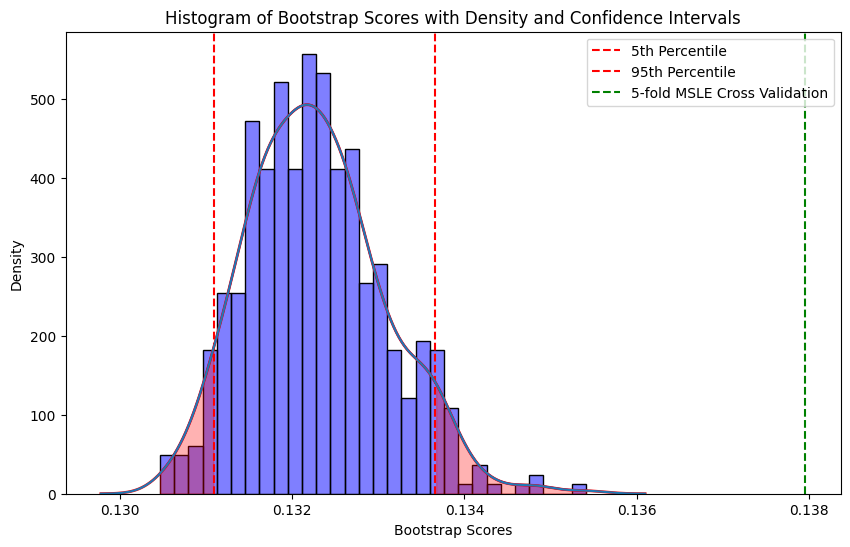

In [74]:
# Made this plot with chatGPT

# Créer une figure
plt.figure(figsize=(10, 6))

# Tracer l'histogramme avec seaborn
sns.histplot(bootstrap_score_MSLE, bins=30, kde=True, stat='density', color='blue', alpha=0.5)

# Ajouter des lignes verticales pour les percentiles
plt.axvline(lower_bound, color='red', linestyle='--', label='5th Percentile')
plt.axvline(upper_bound, color='red', linestyle='--', label='95th Percentile')
plt.axvline(MSLE_model, color='green', linestyle='--', label='5-fold MSLE Cross Validation')

# Tracer la courbe de densité
sns.kdeplot(bootstrap_score_MSLE, color='red', lw=2)

# Remplir la zone sous la courbe de densité en dessous du 5e percentile
x_vals = np.linspace(min(bootstrap_score_MSLE), max(bootstrap_score_MSLE), 1000)
density = sns.kdeplot(bootstrap_score_MSLE).get_lines()[0].get_data()
plt.fill_between(density[0], density[1], where=(density[0] <= lower_bound), color='red', alpha=0.3)

# Remplir la zone sous la courbe de densité au-dessus du 95e percentile
plt.fill_between(density[0], density[1], where=(density[0] >= upper_bound), color='red', alpha=0.3)

# Ajouter les labels et la légende
plt.title('Histogram of Bootstrap Scores with Density and Confidence Intervals')
plt.xlabel('Bootstrap Scores')
plt.ylabel('Density')
plt.legend()

# Afficher le graphique
plt.show()


### Problem

Since it is not working that well, I'll try to bootstrap the entire set as it is stipulated in ISLP.

In [37]:
def get_score_tab_bootstrap_2(X, y, terms, k=5, num_bootstrap=500, score_method_used='RMSE', tqdm_disable=''):
    '''
    Calculate the MSE using k-fold Cross Validation method.

    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        Data from the original preprocessed dataFrame (without the target column)
        
    y : array-like, shape (n_samples,)
        The target value column of the original preprocessed dataFrame.

    terms : array-like, shape (n_selected_features,)
        The predictor variables (or features) used in the model.
        
    k : integer
        how do we slice our dataset (in k parts)

    num_bootstrap : integer
        number of bootstrap train set generated with repetition and then number of scores we get in the end

    score_method_used : string
        The used method to compute the score of our model.

    tqdm_disable : char
        If it is empty, it enables tqdm progression, but if there is a charcter or a string, disable tqdm progression.
        Disable progresson it when it is too heavy to watch the process of the loops, especially when this function is 
        called numerous times.

    Returns:
    --------
    mse : array-like of float, shape (num_bootstrap)
        Array of scores (MSE, R2, or anything else) of every bootstrap sets we made.
    '''

    N_X = X.shape[0] # length of the data

    # check if k is valid
    if k > N_X:
        raise ValueError(f"k cannot be greater than the number of samples. k={k}, but X contains only {X.shape[0]} samples.")

    k_score = np.zeros(k)

    # Shuffle the data
    X_shuffled, y_shuffled = shuffle(X, y, random_state=1)

    # Split the data into k parts
    cutting_data_indice = np.floor(N_X/k).astype(int)

    # Initialize score array
    bootstrap_scores = np.zeros(num_bootstrap)
    
    # Main loop
    for i in tqdm(range(num_bootstrap), disable=tqdm_disable):
        # Generate bootstrap samples with replacement from the original shuffled dataset
        bootstrap_indices = np.random.choice(range(N_X), size=N_X, replace=True)
        X_bootstrap = X_shuffled.iloc[bootstrap_indices]
        y_bootstrap = y_shuffled.iloc[bootstrap_indices]

        # Split the test and train set
        X_train = X_bootstrap[cutting_data_indice+1:]
        y_train = y_bootstrap[cutting_data_indice+1:]

        X_test = X_bootstrap[:cutting_data_indice]
        y_test = y_bootstrap[:cutting_data_indice]

        # Add to the array bootstrap_scores the score gotten in the i_th loop
        bootstrap_scores[i] = evalscore_for_linear_regression(terms, X_train, y_train, X_test, y_test, score_method_used=score_method_used)
    
    return bootstrap_scores

In [38]:
bootstrap_score_MSLE_2 = get_score_tab_bootstrap_2(X=X, y=y, terms=selection[0], k=10, num_bootstrap=500, score_method_used='MSLE', tqdm_disable='')

100%|██████████| 500/500 [00:28<00:00, 17.32it/s]


In [39]:
# Compute the 5th and 95th percentile thresholds
lower_bound_2 = np.percentile(bootstrap_score_MSLE_2, 5)
upper_bound_2 = np.percentile(bootstrap_score_MSLE_2, 95)

# Compute the performance score of my model with cross validation:
MSLE_model_2 = k_fold_CV(X, y, terms=selection[0], k=10, score_method_used='MSLE', tqdm_disable='')

c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
100%|██████████| 10/10 [00:00<00:00, 16.75it/s]


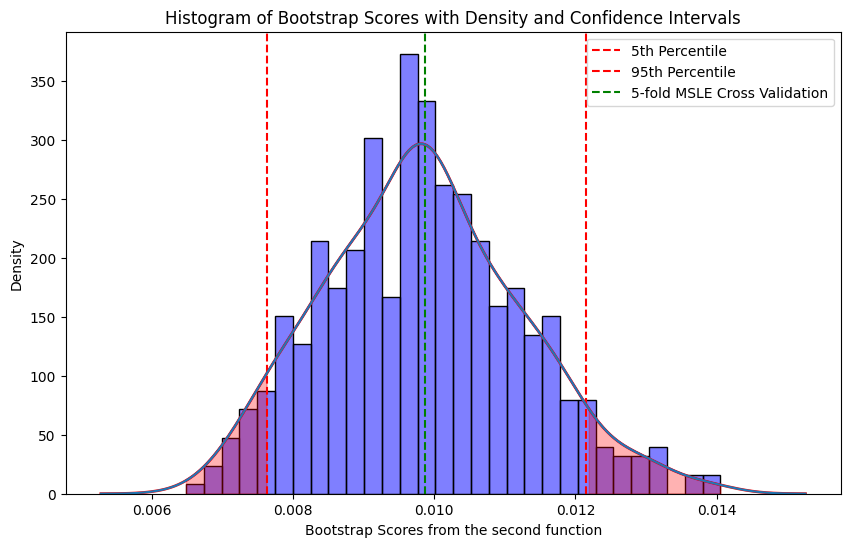

In [40]:
# Made this plot with chatGPT

# Créer une figure
plt.figure(figsize=(10, 6))

# Tracer l'histogramme avec seaborn
sns.histplot(bootstrap_score_MSLE_2, bins=30, kde=True, stat='density', color='blue', alpha=0.5)

# Ajouter des lignes verticales pour les percentiles
plt.axvline(lower_bound_2, color='red', linestyle='--', label='5th Percentile')
plt.axvline(upper_bound_2, color='red', linestyle='--', label='95th Percentile')
plt.axvline(MSLE_model_2, color='green', linestyle='--', label='5-fold MSLE Cross Validation')

# Tracer la courbe de densité
sns.kdeplot(bootstrap_score_MSLE_2, color='red', lw=2)

# Remplir la zone sous la courbe de densité en dessous du 5e percentile
x_vals = np.linspace(min(bootstrap_score_MSLE_2), max(bootstrap_score_MSLE_2), 1000)
density = sns.kdeplot(bootstrap_score_MSLE_2).get_lines()[0].get_data()
plt.fill_between(density[0], density[1], where=(density[0] <= lower_bound_2), color='red', alpha=0.3)

# Remplir la zone sous la courbe de densité au-dessus du 95e percentile
plt.fill_between(density[0], density[1], where=(density[0] >= upper_bound_2), color='red', alpha=0.3)

# Ajouter les labels et la légende
plt.title('Histogram of Bootstrap Scores with Density and Confidence Intervals')
plt.xlabel('Bootstrap Scores from the second function')
plt.ylabel('Density')
plt.legend()

# Afficher le graphique
plt.show()


### Interpretation
- The histogram displays the distribution of Mean Squared Logarithmic Error (MSLE) scores generated through bootstrapping. The central tendency of this distribution represents the average performance of your model on multiple resampled datasets, showing how the model typically performs under varying data subsets.
- The red dashed lines mark the 5th and 95th percentiles, forming a 90% confidence interval. It would means that 90% of the MSLE scores would fall within this range, if we were to resample the data
- The $\sigma^2$ of the computed score seems narrow enough so we can say that our model is adapted enough to our data.